In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from GProtation import make_plot, lnprob
from Kepler_ACF import corr_run
import h5py
from gatspy.periodic import LombScargle
import sys
import os
import time
import emcee
import pyfits

In [21]:
DATA_DIR = "data/"
RESULTS_DIR = "results/"

In [22]:
def load_data(epic_id, DATA_DIR):
    hdulist = pyfits.open(os.path.join(DATA_DIR, "hlsp_everest_k2_llc_{0}-c04_kepler_v1.0_lc.fits".format(epic_id)))
    time, flux = hdulist[1].data["TIME"], hdulist[1].data["FLUX"]
    out = hdulist[1].data["OUTLIER"]
    m = np.isfinite(time) * np.isfinite(flux) * (out < 1)
    med = np.median(flux[m])
    return time[m], flux[m]/med - 1

Load first target.

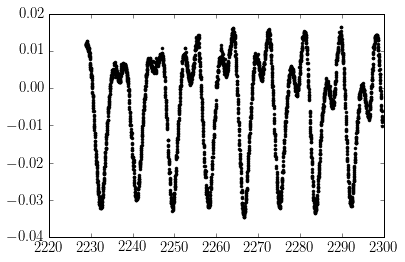

In [23]:
epic_id = 211000411
#epic_id = 211098454
x, y = load_data(epic_id, DATA_DIR)
yerr = np.ones_like(y) * 1e-5
plt.plot(x, y, "k.")

Calculate ACF using McQuillan (2013) code

Calculating ACF...
Calculating errors and asymmetries...


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:1768: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  c = c[Nx - 1 - maxlags:Nx + maxlags]


1/2 P found (1st)
3 Peaks kept
>>>>>>>>>> [  3.06504750e-02   0.00000000e+00  -8.88178420e-16]
1.31716859642e-15
9.31378846491e-16
calculating var for P_med...
saving figure results//211000411_full.png
PERIOD =  7.958906675 +/- 9.31378846491e-16
saving as results//211000411_result.txt
acf period, err =  [ 7.95890668] [  9.31378846e-16]


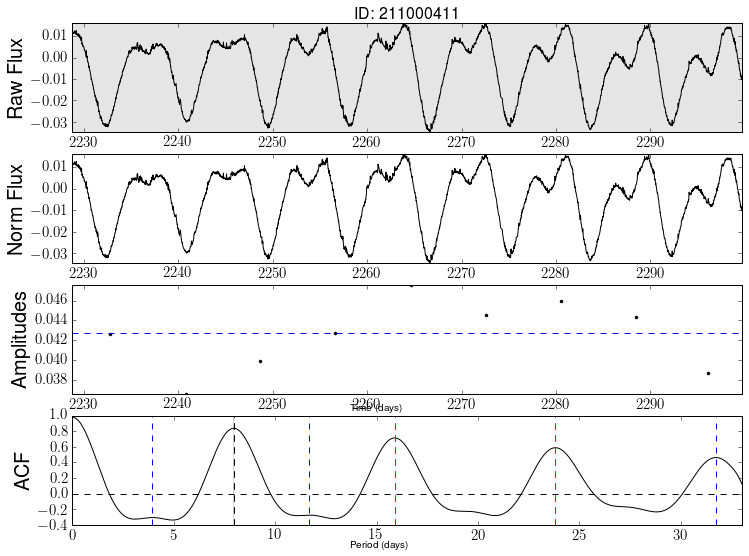

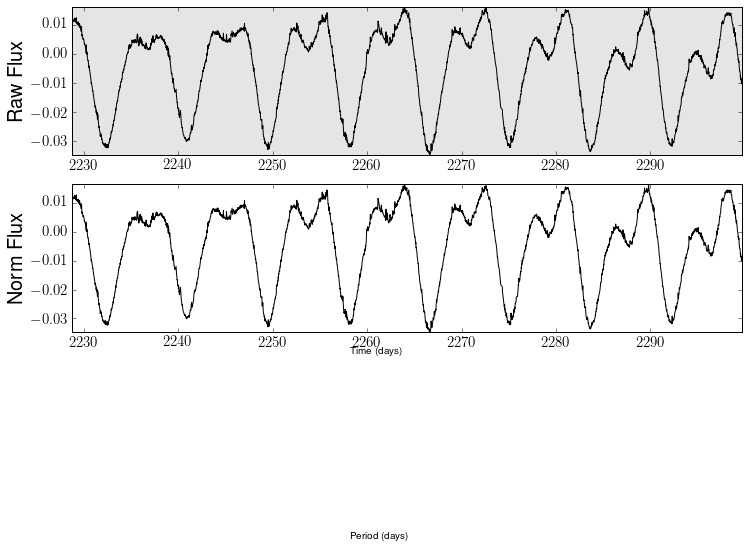

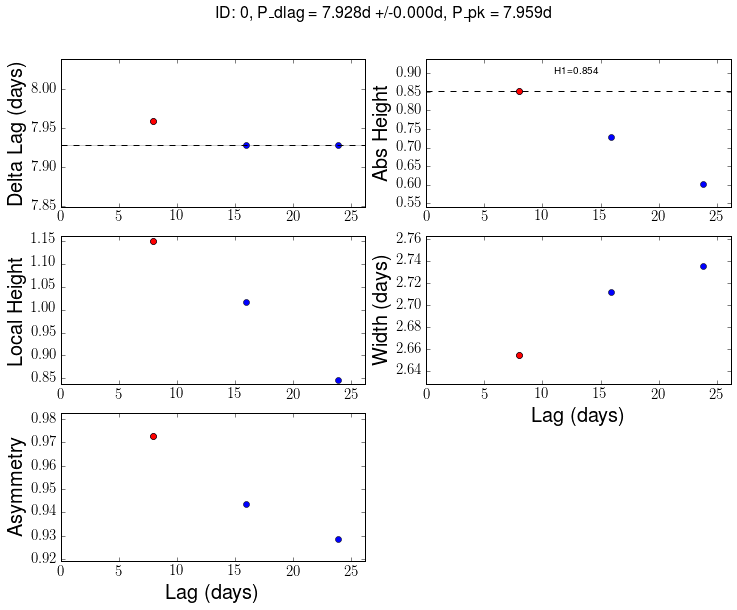

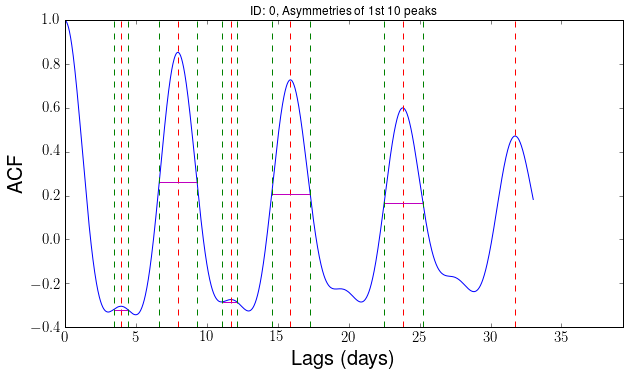

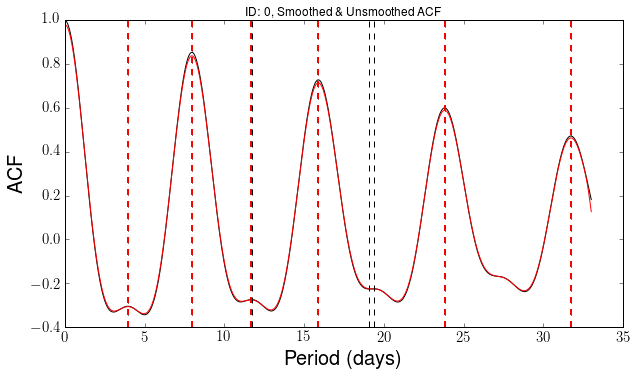

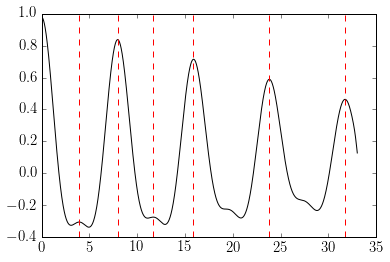

In [24]:
fname = os.path.join(RESULTS_DIR, "{0}_acf_result.txt".format(epic_id))
p_init, err, lags, acf = corr_run(x, y, yerr, epic_id, RESULTS_DIR)
np.savetxt(os.path.join(RESULTS_DIR, "{0}_acf_result.txt".format(epic_id)), np.array([p_init[0], err[0]]).T)
print("acf period, err = ", p_init, err)
plt.plot(lags, acf)

Calculate periodogram

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


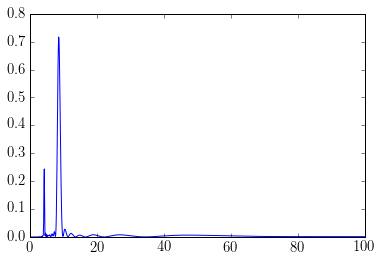

In [25]:
ps = np.arange(.1, 100, .1)
print(type(x), type(y), type(yerr))
model = LombScargle().fit(x, y, yerr)
pgram = model.periodogram(ps)
plt.plot(ps, pgram)

Prep MCMC and set limits on prior.

Subsample the light curve.

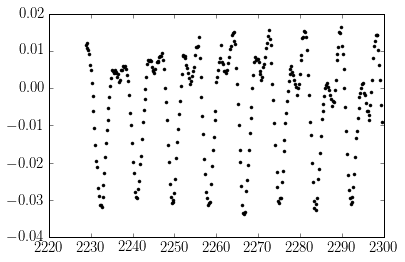

In [26]:
xb, yb, yerrb = x[::10], y[::10], yerr[::10]
plt.plot(xb, yb, "k.")

In [27]:
plims = np.log([.1*p_init, 5*p_init])
print("total number of points = ", len(xb))
theta_init = np.log([np.exp(-5), np.exp(7), np.exp(.6), np.exp(-16), p_init])
burnin, nwalkers = 500, 12
runs = np.zeros(10) + 500
ndim = len(theta_init)
p0 = [theta_init+1e-4*np.random.rand(ndim) for i in range(nwalkers)]
args = (xb, yb, yerrb, plims)

total number of points =  324


Time the LHF call.

In [28]:
start = time.time()
print("lnprob = ", lnprob(theta_init, x, y, yerr, plims))
end = time.time()
tm = end - start
print("1 lhf call takes ", tm, "seconds")
print("burn in will take", tm * nwalkers * burnin, "s")
print("each run will take", tm * nwalkers * runs[0]/60, "mins")
print("total = ", (tm * nwalkers * np.sum(runs) + tm * nwalkers * burnin)/60, "mins")

lnprob =  15710.3164038
1 lhf call takes  0.36086583137512207 seconds
burn in will take 2165.1949882507324 s
each run will take 36.0865831375 mins
total =  396.952414513 mins


Run MCMC.

In [29]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
print("burning in...")
p0, _, state = sampler.run_mcmc(p0, burnin)

sample_array = np.zeros((nwalkers, sum(runs), ndim))
for i, run in enumerate(runs):
    sampler.reset()
    print("production run, {0} steps".format(int(run)))
    start = time.time()
    p0, _, state = sampler.run_mcmc(p0, run)
    end = time.time()
    print("time taken = ", (end - start)/60, "minutes")
    
    # save samples
    sample_array[:, sum(runs[:i]):sum(runs[:(i+1)]), :] = np.array(sampler.chain)
    f = h5py.File(os.path.join(RESULTS_DIR, "{0}.h5".format(epic_id)), "w")
    data = f.create_dataset("samples", np.shape(sample_array[:, :sum(runs[:(i+1)]), :]))
    data[:, :] = sample_array[:, :sum(runs[:(i+1)]), :]
    f.close()
    
    # make various plots
    with h5py.File(os.path.join(RESULTS_DIR, "{0}.h5".format(epic_id)), "r") as f:
        samples = f["samples"][...]
    mcmc_result = make_plot(samples, x, y, yerr, epic_id, RESULTS_DIR, traces=True, tri=True, prediction=True)

burning in...
emcee: Exception while calling your likelihood function:
  params: [ -5.86591975   6.19806771   1.07153448 -14.81355086   2.16170762]
  args: (array([ 2228.8002201 ,  2229.00454332,  2229.20886649,  2229.4131895 ,
        2229.61751245,  2229.82183535,  2230.02615828,  2230.25091344,
        2230.45523605,  2230.65955881,  2230.88431367,  2231.08863631,
        2231.31339104,  2231.51771346,  2231.72203593,  2231.92635814,
        2232.15111271,  2232.37586722,  2232.60062147,  2232.82537574,
        2233.02969785,  2233.23401981,  2233.43834171,  2233.64266366,
        2233.84698545,  2234.05130719,  2234.25562888,  2234.45995061,
        2234.68470434,  2234.90945801,  2235.13421172,  2235.33853302,
        2235.54285447,  2235.74717577,  2235.95149702,  2236.15581831,
        2236.40100368,  2236.62575687,  2236.85050999,  2237.05483096,
        2237.27958407,  2237.5247691 ,  2237.76995406,  2237.99470697,
        2238.19902766,  2238.4033483 ,  2238.62810094,  2238.8

Traceback (most recent call last):
  File "/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/ruthangus/projects/GProtation/ruth/GProtation.py", line 53, in lnprob
    return lnlike(theta, x, y, yerr) + lnprior(theta, plims)
  File "/Users/ruthangus/projects/GProtation/ruth/GProtation.py", line 62, in lnlike
    gp.compute(x, np.sqrt(theta[3]+yerr**2))
  File "/Users/ruthangus/anaconda/lib/python3.5/site-packages/george/gp.py", line 185, in compute
    self.solver.compute(self._x, self._yerr, **kwargs)
KeyboardInterrupt


KeyboardInterrupt: 

Cut out burn in.


 2.25985902175 period (days) 

[ -9.43242788   5.36659646   0.8153376  -13.5224123    0.81530243]
Plotting traces
Making triangle plot
results//211098454_triangle.png
plotting prediction
results//211098454_prediction.png


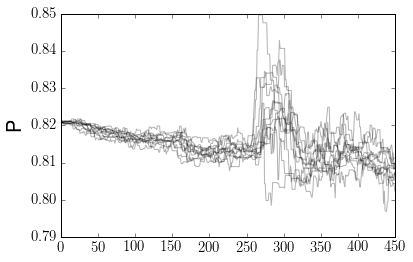

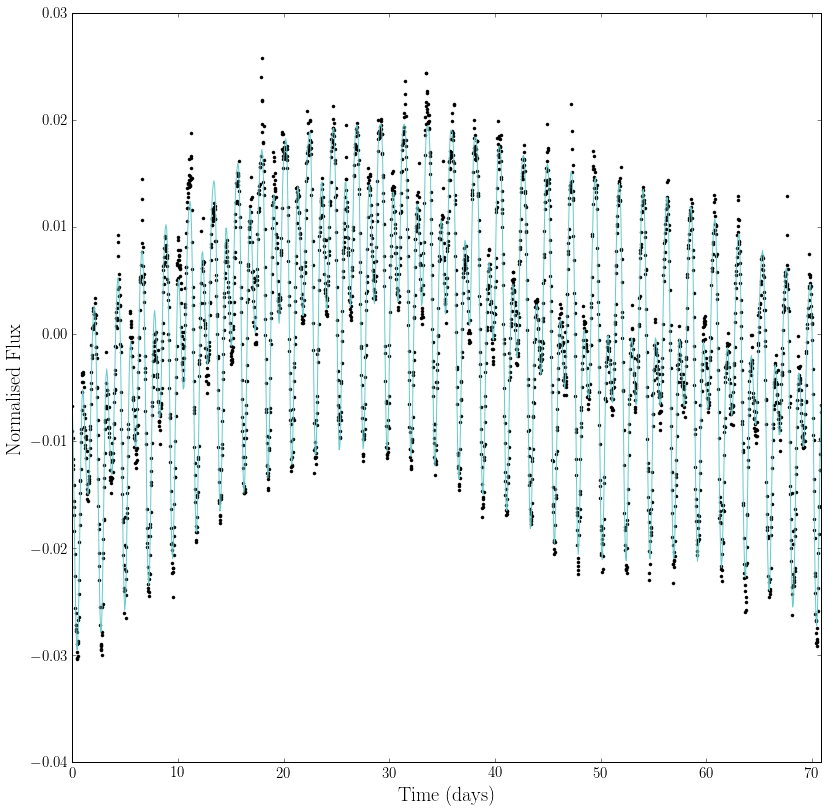

In [22]:
with h5py.File(os.path.join(RESULTS_DIR, "{0}.h5".format(epic_id)), "r") as f:
    samples = f["samples"][...]
samps = samples[:, 300:, :]
mcmc_result = make_plot(samps, x, y, yerr, epic_id, RESULTS_DIR, traces=True, tri=True, prediction=True)